In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json

plt.style.use('plot_style.txt')

In [4]:
import numpy as np
import gpflow
import trieste
from trieste.models.gpflow import build_gpr, GaussianProcessRegression
from trieste.space import Box
from functions import constraints
from functions import objectives
from functools import partial
import pickle

def create_model(search_space, num_rff_features, data):
    gpr = build_gpr(data, search_space, likelihood_variance=1e-7, mean=None)
    return GaussianProcessRegression(gpr, num_rff_features=num_rff_features, use_decoupled_sampler=True)

search_space = Box([0.0, 0.0], [1.0, 1.0])
observer = trieste.objectives.utils.mk_multi_observer(
                OBJECTIVE=objectives.linear_objective,
                INEQUALITY_CONSTRAINT_ONE=constraints.toy_constraint_one,
                INEQUALITY_CONSTRAINT_TWO=constraints.toy_constraint_two)
initial_inputs = search_space.sample(10, seed=42)
initial_data = observer(initial_inputs)
initial_models = trieste.utils.map_values(partial(create_model, search_space, 1000),
                                          initial_data)

In [5]:
initial_models["OBJECTIVE"].model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,(),float64,1.1233
GPR.kernel.variance,Parameter,Softplus,LogNormal,True,(),float64,0.24533
GPR.kernel.lengthscales,Parameter,Softplus,LogNormal,True,"(2,)",float64,[0.28284 0.28284]
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.0
GPR.data[0],ResourceVariable,,,False,"(None, 2)",float64,"[[0.33042, 0.83747..."
GPR.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[1.16789...


In [6]:
initial_models["OBJECTIVE"].model.mean_function

In [17]:
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"

In [19]:
def process_ts_results(result_dir: str,
                       num_runs: int,
                       failure_val: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [20]:
def process_original_albo_results(result_dir: str,
                                  num_runs: int,
                                  failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            all_results.append(run_results)
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [197]:
original_albo_no_slack_results, original_albo_no_slack_results_mean, original_albo_no_slack_results_median, original_albo_no_slack_results_std = process_original_albo_results("../results/original_albo/lockwood/no_slack_fully_consistent/data/", 30, 6)
original_albo_no_slack_fully_consistent_results, original_albo_no_slack_fully_consistent_results_mean, original_albo_no_slack_fully_consistent_results_median, original_albo_no_slack_fully_consistent_results_std = process_original_albo_results("../results/original_albo/lockwood/no_slack_fully_consistent_6000_initial_samples/data/", 30, 6)
original_albo_slack_results, original_albo_slack_results_mean, original_albo_slack_results_median, original_albo_slack_results_std = process_original_albo_results("../results/original_albo/lockwood/slack_optim/data/", 30, 60000)
random_results, random_results_mean, random_results_median, random_results_std = process_ts_results("../results/20-04-23/lockwood_random/data/", 30, 6)
ts_results, ts_results_mean, ts_results_median, ts_results_std = process_ts_results("../results/21-04-23/lockwood_slack/data/", 6, 6)
ts_reduced_lbfgs_results, ts_reduced_lbfgs_results_mean, ts_reduced_lbfgs_results_median, ts_reduced_lbfgs_results_std = process_ts_results("../results/24-04-23/lockwood_6000_samples_2_bfgs/data/", 6, 6)
ts_no_optim_results, ts_no_optim_results_mean, ts_no_optim_results_median, ts_no_optim_results_std = process_ts_results("../results/25-04-23/lockwood_no_optim/data/", 23, 6)

In [103]:
with open("../results/21-04-23/lockwood_slack/data/run_4_data.pkl", "rb") as fp:
    data = pickle.load(fp)

In [104]:
min(data['OBJECTIVE'].observations[np.logical_and(data['INEQUALITY_CONSTRAINT_ONE'].observations <= 0, data['INEQUALITY_CONSTRAINT_TWO'].observations <= 0)])

<tf.Tensor: shape=(), dtype=float64, numpy=2.527397>

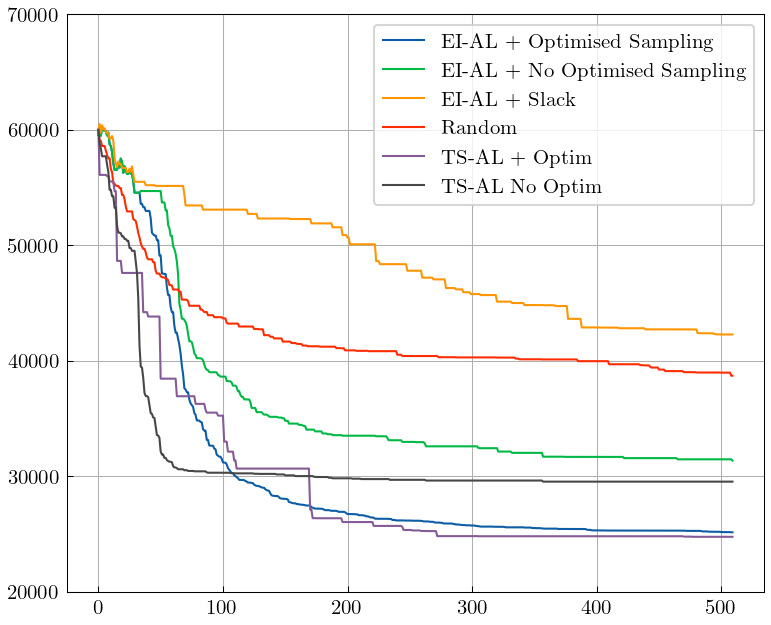

In [198]:
plt.figure(figsize=(6,5))
plt.plot(original_albo_no_slack_results_mean * 10000, label="EI-AL + Optimised Sampling")
plt.plot(original_albo_no_slack_fully_consistent_results_mean * 10000, label="EI-AL + No Optimised Sampling")
plt.plot(original_albo_slack_results_mean, label="EI-AL + Slack")
plt.plot(random_results_mean * 10000, label="Random")
# plt.plot(ts_results_mean * 10000)
plt.plot(ts_reduced_lbfgs_results_mean * 10000, label="TS-AL + Optim")
plt.plot(ts_no_optim_results_mean * 10000, label="TS-AL No Optim")
plt.ylim(20000, 70000)
plt.legend()

In [199]:
print(ts_no_optim_results[:,-1])

[2.935547 2.935547 2.935547 2.935547 2.935547 2.935547 2.935547 2.935547
 2.935547 2.935547 2.935547 2.935547 2.935547 2.935547 3.014404 2.935547
 2.935547 2.935547 2.935547 2.935547 2.935547 3.121857 3.080566]


In [33]:
print(random_results[:,-1])

[4.199853 3.934676 3.792885 3.805823 3.504884 3.119033 4.120344 3.702142
 3.798054 4.543324]


In [106]:
print(original_albo_slack_results[:,500])

[31252.94 38155.92 29680.55 43400.61 28432.38 36765.12 37500.9  49636.86
 32001.09 29090.6  42582.38 56837.04]


In [148]:
print(ts_reduced_lbfgs_results[:,170])

[2.627517 2.608237 2.468735 2.921543 2.947247 2.699897]


In [114]:
print(original_albo_no_slack_results[:,340])

[2.506276 2.579715 2.504139 2.488715 2.453001 2.631409 2.681275 2.592811
 2.454338 2.641616 2.506603 2.627986 2.471793 2.525007 2.563887 2.508309
 2.576629 2.504943 2.574964 2.609251 2.518174 2.572199 2.56866  2.599249
 2.532437 2.560467 2.618978 2.596464 2.564416 2.60218 ]


In [123]:
print(ts_results[:, 200])

[2.735733 2.584304 2.612877 2.358544 2.527397 2.446437]


In [120]:
print(np.mean(ts_results[:,-1]))

2.4931453333333335


In [154]:
run = 2
with open(f"../results/24-04-23/lockwood_6000_samples_2_bfgs/data/run_{run}_inequality_lambda_progression.pkl", "rb") as fp:
    ineq_lambd = pickle.load(fp)

In [155]:
ineq_lambd

{'INEQUALITY_CONSTRAINT_ONE': [<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.

In [8]:
import tensorflow as tf

2023-04-20 17:05:22.398238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
x = tf.Variable(0.0)
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y = tf.nn.relu(x)

In [15]:
tape.gradient(y, x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>